<a href="https://colab.research.google.com/github/Malebrenchs/Tower-Crane-Optimization/blob/main/Programa_integrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Características de la torre grúa

## LECTURA DE BD DE EXCEL

In [1]:
import pandas as pd
import sqlite3

# El siguiente comando solo funciona en Google Colab
# Intenta emplear la librería, en caso no se pueda, probablemente es porque se está usando Jupyter offline
# Solicita subir un archivo excel con la información de las fichas técnicas de Torres grúa según el formato que se planteó
try:
    from google.colab import files
    print("Sube tu archivo 'BD GRÚAS.xlsx':")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
except ImportError:
    file_path = 'BD GRÚAS.xlsx'

# Usando "sheet_name=None" se cargan todas las hojas que contiene el excel en un diccionario (yo le puse xls)
# Las keys del diccionario son los nombres de las hojas y los values son los dataframes de pandas con el contenido de cada hoja
xls = pd.read_excel(file_path, sheet_name=None)

# Crea una base de datos SQL llamada gruadb para guardar los dataframes allí y poder posteriormente extraer los datos con comandos de SQL
conn = sqlite3.connect('gruadb.sqlite')

# Parte del código que guarda cada los items (par key-value) del diccionario xls a la base de datos SQL gruadb
# Se guarda con el mismo nombre de la hoja (sheet_name), se conecta a gruadb, si existe una tabla la reemplaza y no guarda los índices de los dataframes de panda
for sheet_name, df in xls.items():
    df.to_sql(sheet_name, conn, if_exists='replace', index=False)
    print(f"Tabla '{sheet_name}' creada con {len(df)} registros.")

# Cierro la conexion con la Base de datos (por si acaso, no es necesario porque se usa posteriormente)
conn.close()

Sube tu archivo 'BD GRÚAS.xlsx':


Saving BD GRÚAS.xlsx to BD GRÚAS.xlsx
Tabla 'Marca' creada con 2 registros.
Tabla 'Modelos de grúas' creada con 5 registros.
Tabla 'Curva de carga' creada con 89 registros.
Tabla 'Notas' creada con 4 registros.


## OBTENCIÓN DE DATOS DE GRÚA DESEADA

In [2]:
# Guardar pares Radio‑Capacidad en df_analisis
# Vuelvo a abrir la base de datos. Podría no cerrar siempre la BD pero prefiero mantener la costumbre
conn = sqlite3.connect('gruadb.sqlite')

# Cargar tablas desde el archivo Excel empleando SQL, almacena marca, modelo y la curva de fuerza de las torres grúa
# Usa conn porque obtiene la información de la base de datos gruadb.sqlite
df_marca   = pd.read_sql("SELECT * FROM Marca", conn)
df_modelos = pd.read_sql('SELECT * FROM "Modelos de grúas"', conn)
df_curva   = pd.read_sql('SELECT * FROM "Curva de carga"', conn)

# Selección de marcas disponibles de torres grúa en la Base de Datos (BD)
# Muestra las marcas disponibles, ignora el index del dataframe y muestra los valores de BrandID y Name para escoger
# row (una serie de pandas) lee una fila individual a lo largo de marca.iterrows que itera en cada fila del dataframe
print("Marcas disponibles:")
for _, row in df_marca.iterrows():
    print(f"{row['BrandID']} - {row['Name']}")

# Selección de Marca
# Uso .strip solo por si acaso, elimina espacios al inicio y al final
# Exige un input que podrá ser el BrandID o el nombre de la marca (casi siempre uso el BrandID)
# Si lo ingresado son números enteros (que es lo que se supone es el BrandID) y lo ingresado se encuentra dentro de df_marca entonces lo guarda en bid
# df_marca['BrandID'] brinda solo la columna BrandID de df_marca
# Uso .values para convertirlo a un array de numpy solo por si acaso, no es obligatorio
# En caso se haya ingresado el nombre de la marca, se filtra el dataframe, buscando encontrar el BrandID correspondiente a esa marca
# El filtrado lo hace .loc
# Se usa .iloc[0] para que, en caso existan mulitples valores que cumplan la condición, se escoja el primero (no debería ser el caso, un BrandID debería corresponder a un solo nombre de marca, pero lo coloco por si acaso)
seleccion = input("\nIngresa el BrandID o Name de la marca: ").strip()
if seleccion.isdigit() and int(seleccion) in df_marca['BrandID'].values:
    bid = int(seleccion)
else:
    bid = df_marca.loc[df_marca['Name'] == seleccion, 'BrandID'].iloc[0]

# Una vez seleccionada la marca, ahora se selecciona el modelo
# Crea un dataframe más pequeño llamado modelos_filtrados que se compone de los modelos que tengan el BrandID que se seleccionó previamente
# Realiza un print a esos modelos filtrados
# Recorre todos los modelos filtrados para que se seleccione el que necesite
# Selecciona el modelo que se requiera
modelos_filtrados = df_modelos[df_modelos['BrandID'] == bid]
print(f"\nModelos de {df_marca.loc[df_marca['BrandID']==bid,'Name'].iloc[0]}:")
for _, row in modelos_filtrados.iterrows():
    print(f"{row['CraneModel-ID']} - {row['ModelName']}")

seleccion_modelo = input("\nIngresa el CraneModel-ID o ModelName: ").strip()

# Si lo ingresado es un número correspondiente a el CraneModel-ID, entonces guarda ese CraneModel-ID en cmid
# Si se ingresa el nombre del modelo, busca ese nombre en la columna ModelName y brinda el CraneModel-ID correspondiente a ese nombre
# Con .iloc[0] brinda el primer resultado que encuentre (que debería ser el único, pero por si acaso lo coloco, nunca se sabe)
# Adicionalmente se busca la fila en la que se encuentra el CraneModel-ID para filtrar con ella posteriormente (variable "fila")
# Busca que el BrandID asociado al modelo seleccionado sea el correcto (última condición del if y la más larga)
if seleccion_modelo.isdigit() and int(seleccion_modelo) in df_modelos['CraneModel-ID'].values and df_modelos.loc[df_modelos['CraneModel-ID']==int(seleccion_modelo),'BrandID'].iloc[0]==bid:
    cmid = int(seleccion_modelo)
    fila = df_modelos.loc[df_modelos['CraneModel-ID'] == cmid].iloc[0]
else:
    # Se usa una máscara booleana para determinar si el modelo se encuentra dentro del listado de modelos (no lo usé para las marcas, estoy probando)
    mask = df_modelos['ModelName'].astype(str) == seleccion_modelo
    if not mask.any():
        raise ValueError("Modelo no encontrado. Usa un CraneModel-ID válido o el ModelName exacto.")
    fila = df_modelos.loc[mask].iloc[0]
    cmid = int(fila['CraneModel-ID'])

# Crea un dataframe final que se analizará posteriormente llamado df_analisis
# Este dataframe se compone de los datos de el dataframe df_curva que coincidan con el CraneModel-ID seleccionado
# Los datos son pares radio-capacidad de la grúa seleccionada
# Se usa .reset_index(drop=True) para resetar los index desde 0
df_analisis = (
    df_curva
    .loc[df_curva['CraneModel-ID'] == cmid, ['Radio', 'Capacidad']]
    .reset_index(drop=True)
)

# Realiza un print a df_analisis
print("\nDataFrame df_analisis (Radio vs Capacity):")
print(df_analisis)

# Cerrar conexión
conn.close()

Marcas disponibles:
1 - Potain
2 - Liebherr

Ingresa el BrandID o Name de la marca: 1

Modelos de Potain:
1 - MD559
2 - MD569

Ingresa el CraneModel-ID o ModelName: 1

DataFrame df_analisis (Radio vs Capacity):
    Radio  Capacidad
0    22.0       20.0
1    25.0       20.0
2    27.0       18.7
3    30.0       16.5
4    32.0       15.3
5    35.0       13.7
6    37.0       12.8
7    40.0       11.6
8    42.0       10.9
9    45.0       10.1
10   47.0        9.6
11   50.0        8.8
12   52.0        8.4
13   55.0        7.9
14   57.0        7.5
15   60.0        7.0
16   62.0        6.7
17   65.0        6.3
18   67.0        6.1
19   70.0        5.7
20   72.0        5.4
21   75.0        5.0
22   77.0        4.8
23   80.0        4.4


In [3]:
# Se obtienen parámetros del modelo de grúa seleccionado (usando la variable fila). Se emplea errors=coerce para obtener NaN en caso de no tener un número
HOOK_HEIGHT = pd.to_numeric(fila["HookHeight"], errors="coerce")
RADIO_MIN   = pd.to_numeric(fila["Radio_min"], errors="coerce")
MAX_LENGHT  = pd.to_numeric(fila["Max_Lenght"], errors="coerce")
MAX_WEIGHT  = pd.to_numeric(fila["Max_weight"], errors="coerce")

print(f"\nVariables listas para cálculos → HOOK_HEIGHT={HOOK_HEIGHT}, RADIO_MIN={RADIO_MIN}, MAX_LENGHT={MAX_LENGHT}, MAX_WEIGHT={MAX_WEIGHT}")



Variables listas para cálculos → HOOK_HEIGHT=81.5, RADIO_MIN=2.9, MAX_LENGHT=80.0, MAX_WEIGHT=20


## CÁLCULO DE PARÁMETROS CONSIDERANDO D=1

In [4]:
# En esta celda se realiza el cálculo de parámetros para emplear la fórmula de Margaret Emsley para obtener predicciones de la capacidad de carga de una torre grúa
# En función de los pares radio-capacidad se debe poder obtener la capacidad para cada punto de la grúa.
# Se realiza la obtención del máximo valor del dataframe analizado
max_cap = df_analisis['Capacidad'].max()

# Debido a que pueden existir multiples puntos que tengan la máxima capacidad de carga (los primeros metros de alcance de la torre grúa) se busca un subconjunto que cumpla con tener la capacidad de carga máxima
subset = df_analisis[df_analisis['Capacidad'] == max_cap]

# Dentro de ese subconjunto, se obtiene el par que tenga el valor de radio más grande, así poder saber dónde empieza a decrecer la capacidad de carga de la grúa
high_row = subset.loc[subset['Radio'].idxmax()]
print(high_row)

# Se realiza el mismo procedimiento con el par de menor capacidad de carga
# No debería existir 2 mínimos, pero por si acaso se realiza el filtrado igual que el caso anterior
min_cap = df_analisis['Capacidad'].min()
subset_min = df_analisis[df_analisis['Capacidad'] == min_cap]
low_row = subset_min.loc[subset_min['Radio'].idxmax()]
print("\n",low_row)

# Cálculo de parámetros Pmax/min y Rmax/min
# Se asigna los valores máximos y mínimos para el radio (R) y capacidad de carga (P)
# Se multiplica por 1000 a la carga porque el dato está en toneladas y el procesamiento se realiza en kg
# Nótese que para la capacidad de carga máxima, corresponde el radio mínimo y para la capacidad de carga mínima, corresponde el radio máximo
Pmax=high_row['Capacidad']*1000
Rmin=high_row['Radio']

Pmin=low_row['Capacidad']*1000
Rmax=low_row['Radio']

# De acuerdo a la fórmula de Margaret Emsley, es necesario establecer un parámetro arbitrario de distancia entre el eje de la grúa y el punto de análisis de momentos
# En sus textos, indica que se pueden usar los valores de 1m o 1.23m, en este caso empleamos 1 pero es de fácil cambio en caso sea necesario
D=1

# Primero se hayan los parámetros Q y M (asociados al peso del trolley de la grúa y al momento en el punto de análisis respectivamente)
Q=round((Pmax*(Rmin-D)-Pmin*(Rmax-D))/(Rmax-Rmin),2)
print("\nValor de Q =",Q," kg")
M=round((Pmax+Q)*(Rmin-D),2)
print("Valor de M =",M," kg.m")

Radio        25.0
Capacidad    20.0
Name: 1, dtype: float64

 Radio        80.0
Capacidad     4.4
Name: 23, dtype: float64

Valor de Q = 2407.27  kg
Valor de M = 537774.48  kg.m


## OPERACIONALIZACIÓN Y PREDICCIÓN DE CARGAS

In [26]:
# Para la predicción de cargas para un radio determinado, se plantea crear un dataframe "df_between" que albergue los pares radio-carga de la grúa que integren la parte no constante de la curva de cargas de la torre grúa
# Solo en caso de que en el excel los datos no se hayan registrado al revés, se emplea esta línea para determinar el radio mínimo y máximo de esta serie
r_min, r_max = min(high_row['Radio'], low_row ['Radio']), max(high_row['Radio'], low_row ['Radio'])

# De todos los pares radio-carga del dataframe de análisis, tomamos solo los pares con capacidad de carga no constante
# Se condiciona a tomar solo las filas cuyo valor de radio esté en entre el mínimo y máximo determinado
# Se usa reset_index(drop=True) para que los índices se vuelvan a contar desde cero
df_between = df_analisis[
    (df_analisis['Radio'] >= r_min) &
    (df_analisis['Radio'] <= r_max)
].reset_index(drop=True)

# Creamos un dataframe de predicción que contendrá la carga predicha para los radios anteriormente extraídos
# Copiamos inicialmente el df_between para tener los radios que usaremos para la predicción
df_prediccion = df_between[['Radio']].copy()

# Agregamos una columna donde empleamos la fórmula proporcionada por el trabajo de Margaret Emsley para predecir la capacidad de carga en función a M, D y Q, redondeado a 2 decimales
df_prediccion['Prediccion_Carga'] = round(M /(df_between['Radio']-D)-Q,2)

# Agregamos una columna donde determinamos un error porcentual para saber donde ocurren las diferencias más grandes entre las capacidades reales y predichas, además de su magnitud
df_prediccion['Error %'] = round(100*(df_between['Capacidad']*1000-df_prediccion['Prediccion_Carga'])/df_between['Capacidad']/1000,2)

# Verifica el resultado
print("Predicción de cargas y error porcentual\n")
print(df_prediccion)

# Adicionalmente calcularemos el error máximo que ocurre en nuestros datos
# Este estará determinado por la comparación del valor absoluto de todos los errores
idx = abs(df_prediccion['Error %']).idxmax()

# Buscamos en qué fila ocurre este error máximo y lo mostramos empleando un print
row_max_error = df_prediccion.loc[idx]
print(f"\nEl mayor error ({row_max_error['Error %']:.2f}%) ocurre en Radio = {row_max_error['Radio']} m")


Predicción de cargas y error porcentual

    Radio  Prediccion_Carga  Error %
0    25.0          20000.00     0.00
1    27.0          18276.36     2.27
2    30.0          16136.68     2.20
3    32.0          14940.29     2.35
4    35.0          13409.63     2.12
5    37.0          12530.91     2.10
6    40.0          11381.82     1.88
7    42.0          10709.18     1.75
8    45.0           9814.88     2.82
9    47.0           9283.48     3.30
10   50.0           8567.72     2.64
11   52.0           8137.33     3.13
12   55.0           7551.52     4.41
13   57.0           7195.85     4.06
14   60.0           6707.55     4.18
15   62.0           6408.71     4.35
16   65.0           5995.46     4.83
17   67.0           5740.83     5.89
18   70.0           5386.56     5.50
19   72.0           5167.02     4.31
20   75.0           4859.95     2.80
21   77.0           4668.71     2.74
22   80.0           4400.00     0.00

El mayor error (5.89%) ocurre en Radio = 67.0 m


Gráfica de comparación Capacidad real vs Capacidad predicha


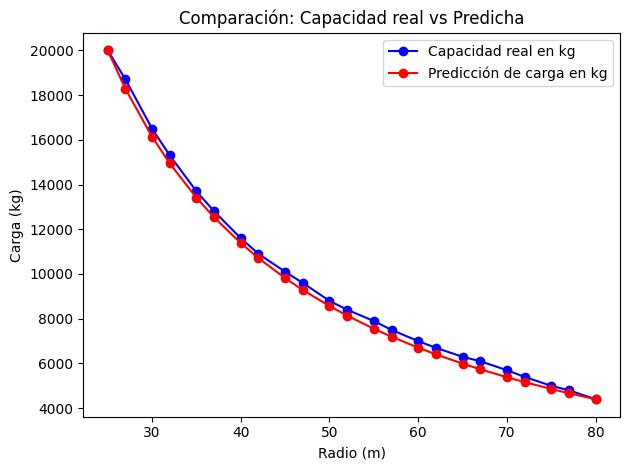

In [6]:
print("Gráfica de comparación Capacidad real vs Capacidad predicha")
import matplotlib.pyplot as plt

# Si necesitas regenerar df_between y df_prediccion en este bloque, hazlo antes de la gráfica.
# Aquí asumimos que df_between y df_prediccion están definidos.

plt.figure()
plt.plot(df_between['Radio'], df_between['Capacidad'] * 1000,
         marker='o', linestyle='-', color='blue', label='Capacidad real en kg')
plt.plot(df_prediccion['Radio'], df_prediccion['Prediccion_Carga'],
         marker='o', linestyle='-', color='red', label='Predicción de carga en kg')
plt.xlabel('Radio (m)')
plt.ylabel('Carga (kg)')
plt.title('Comparación: Capacidad real vs Predicha')
plt.legend()
plt.tight_layout()
plt.show()


# Límite de construcción, nodos logísticos, materiales a transportar y demanda de cada nodo


In [7]:
# === 1) Subir el Excel ===
print("Sube tu archivo Excel (ej.: Puntos de analisis.xlsx)")
uploaded = files.upload()                      # Abre el diálogo de subida
file_path = list(uploaded.keys())[0]           # Toma el nombre del archivo subido

# === 2) Leer hojas específicas a DataFrames ===
#   Nombres de hoja esperados: 'LIMITES', 'NODOS', 'PosicionGrua', 'Materiales', 'Demanda'
df_limites = pd.read_excel(file_path, sheet_name='LIMITES')
df_nodos   = pd.read_excel(file_path, sheet_name='NODOS')
df_grua    = pd.read_excel(file_path, sheet_name='PosicionGrua')
df_materiales = pd.read_excel(file_path, sheet_name='Materiales')  # Nueva hoja
df_demanda = pd.read_excel(file_path, sheet_name='Demanda')        # Nueva hoja

# === 3) (Opcional) Normalizar tipos de datos ===
# Fuerza a float las coordenadas si vinieran como texto
for df in (df_limites, df_nodos, df_grua, df_materiales, df_demanda):
    for col in df.columns:
        if col.endswith('_m'):
            df[col] = pd.to_numeric(df[col], errors='coerce')

# === 4) Confirmación rápida ===
print("\nLectura completada.")
print("df_limites:", df_limites.shape)
print("df_nodos  :", df_nodos.shape)
print("df_grua   :", df_grua.shape)
print("df_materiales:", df_materiales.shape)
print("df_demanda  :", df_demanda.shape)

print("\nVista rápida de cada DF:")
print("\nLIMITES")
print(df_limites.head())
print("\nNODOS")
print(df_nodos.head())
print("\nPosicionGrua")
print(df_grua.head())
print("\nMateriales")
print(df_materiales.head())
print("\nDemanda")
print(df_demanda.head())

Sube tu archivo Excel (ej.: Puntos de analisis.xlsx)


Saving Puntos de analisis.xlsx to Puntos de analisis.xlsx

Lectura completada.
df_limites: (4, 4)
df_nodos  : (3, 4)
df_grua   : (3, 4)
df_materiales: (5, 4)
df_demanda  : (5, 4)

Vista rápida de cada DF:

LIMITES
  VerticeID  X_m  Y_m  Z_m
0        L1    0    0    0
1        L2   50    0    0
2        L3   50   30    0
3        L4    0   30    0

NODOS
  NodeID  X_m  Y_m  Z_m
0     N1   10    5    0
1     N2   40   20    0
2     N3   45   25    0

PosicionGrua
  CraneID  X_m  Y_m  Z_m
0      C1   12   12    0
1      C2   25   15    0
2      C3   35   10    0

Materiales
  Material_ID                 Nombre  Peso_unidad_kg   Unidad
0        CEME       Bolsa de cemento            42.5    bolsa
1        LADR  Ladrillo KK 18 huecos             2.7   unidad
2        ACER       Varilla de acero            20.0  varilla
3        VIGA      Viga prefabricada           144.0   unidad
4        ENCO              Encofrado            32.0       m2

Demanda
  FromNode ToNode Material_ID  Cantidad
0

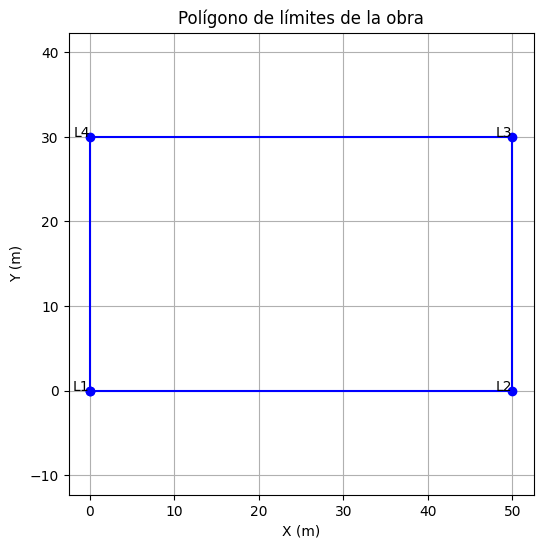

In [8]:
# Ejemplo de df_limites basado en lo que el usuario describió (un rectángulo 50x30)
# LOS VERTICES EN EL EXCEL DEBEN ESTAR EN ORDEN HORARIO O ANTIHORARIO PERO SIEMPRE EN ALGUNO DE ESOS 2 ORDENES
# PARA QUE EL POLÍGONO TENGA SENTIDO

df_limites = pd.DataFrame({
    "VerticeID": ["L1", "L2", "L3", "L4"],
    "X_m": [0, 50, 50, 0],
    "Y_m": [0, 0, 30, 30],
    "Z_m": [0, 0, 0, 0]
})

# Graficar el polígono con matplotlib
x = df_limites['X_m'].tolist()
y = df_limites['Y_m'].tolist()

# Cerrar el polígono
x.append(x[0])
y.append(y[0])

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
for i, (xi, yi, vid) in enumerate(zip(df_limites['X_m'], df_limites['Y_m'], df_limites['VerticeID'])):
    plt.text(xi, yi, vid, fontsize=10, ha='right')
plt.title("Polígono de límites de la obra")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('equal')
plt.grid(True)
plt.show()


Construye el polígono desde LIMITES.

Usa Ray Casting (con chequeo de punto en borde) para cada punto de NODOS y PosicionGrua.

Devuelve dos DataFrames validados:

df_nodos_val

df_grua_val

Agrega columnas:

duplicado_coord (por X_m, Y_m),

coincide_vertice (si coincide con un vértice del límite),

en_poligono (True si dentro o en borde),

estado (OK, duplicado, coincide_vertice, fuera).

Crea también df_nodos_ok y df_grua_ok con solo los puntos válidos para que los uses en los siguientes pasos.

In [9]:
import numpy as np

# 1) Preparar polígono (lista de (x,y)) a partir de df_limites
polygon = list(zip(df_limites['X_m'].tolist(), df_limites['Y_m'].tolist()))
vertices_set = set(polygon)  # para detección rápida de coincidencia con vértice

# 2) Algoritmo Ray Casting robusto (con detección de borde)
def _on_segment(px, py, ax, ay, bx, by, eps=1e-9):
    # verifica si P está sobre el segmento AB (incluye extremos)
    cross = (px - ax)*(by - ay) - (py - ay)*(bx - ax)
    if abs(cross) > eps:
        return False
    dot = (px - ax)*(bx - ax) + (py - ay)*(by - ay)
    if dot < -eps:
        return False
    sq_len = (bx - ax)**2 + (by - ay)**2
    if dot - sq_len > eps:
        return False
    return True

def punto_en_poligono(punto, poligono, eps=1e-12):
    """Ray casting con detección de borde.
    Devuelve True si está dentro o SOBRE el borde; False si fuera."""
    x, y = punto
    inside = False
    n = len(poligono)

    for i in range(n):
        x1, y1 = poligono[i]
        x2, y2 = poligono[(i + 1) % n]

        # Punto sobre borde
        if _on_segment(x, y, x1, y1, x2, y2):
            return True

        # Cruce con el rayo horizontal hacia +x
        # Comprobamos si el segmento cruza la horizontal del punto
        intersects = ((y1 > y) != (y2 > y)) and \
                     (x < (x2 - x1) * (y - y1) / (y2 - y1 + eps) + x1)
        if intersects:
            inside = not inside

    return inside

# 3) Función de validación para un DataFrame de puntos
def validar_puntos(df_points, id_col='NodeID'):
    df = df_points.copy()
    # duplicados por coordenadas
    df['duplicado_coord'] = df.duplicated(subset=['X_m', 'Y_m'], keep='first')
    # coincide con vértice
    df['coincide_vertice'] = list(zip(df['X_m'], df['Y_m']))
    df['coincide_vertice'] = df['coincide_vertice'].apply(lambda p: p in vertices_set)
    # dentro del polígono (incluye borde)
    df['en_poligono'] = list(zip(df['X_m'], df['Y_m']))
    df['en_poligono'] = df['en_poligono'].apply(lambda p: punto_en_poligono(p, polygon))
    # estado resumido
    df['estado'] = np.where(df['duplicado_coord'], 'duplicado',
                    np.where(df['coincide_vertice'], 'coincide_vertice',
                    np.where(df['en_poligono'], 'OK', 'fuera')))
    return df

# 4) Aplicar a NODOS y a PosicionGrua
df_nodos_val = validar_puntos(df_nodos, id_col='NodeID')
df_grua_val  = validar_puntos(df_grua,  id_col='CraneID')

# 5) Resultados y resumen
print("\n=== RESUMEN NODOS ===")
print(df_nodos_val[['NodeID','X_m','Y_m','en_poligono','coincide_vertice','duplicado_coord','estado']])
print("\nConteos:\n", df_nodos_val['estado'].value_counts())

print("\n=== RESUMEN POSICIONES DE GRÚA ===")
# En PosicionGrua la columna de ID suele ser 'CraneID'
id_col_grua = 'CraneID' if 'CraneID' in df_grua_val.columns else (df_grua_val.columns[0])
cols_grua = [id_col_grua,'X_m','Y_m','en_poligono','coincide_vertice','duplicado_coord','estado']
print(df_grua_val[cols_grua])
print("\nConteos:\n", df_grua_val['estado'].value_counts())

# (Opcional) Si quieres DataFrames limpios con sólo las filas válidas:
df_nodos_ok = df_nodos_val[df_nodos_val['estado'] == 'OK'].reset_index(drop=True)
df_grua_ok  = df_grua_val[df_grua_val['estado']  == 'OK'].reset_index(drop=True)

print("\nNodos válidos (OK):", len(df_nodos_ok))
print("Candidatos de grúa válidos (OK):", len(df_grua_ok))



=== RESUMEN NODOS ===
  NodeID  X_m  Y_m  en_poligono  coincide_vertice  duplicado_coord estado
0     N1   10    5         True             False            False     OK
1     N2   40   20         True             False            False     OK
2     N3   45   25         True             False            False     OK

Conteos:
 estado
OK    3
Name: count, dtype: int64

=== RESUMEN POSICIONES DE GRÚA ===
  CraneID  X_m  Y_m  en_poligono  coincide_vertice  duplicado_coord estado
0      C1   12   12         True             False            False     OK
1      C2   25   15         True             False            False     OK
2      C3   35   10         True             False            False     OK

Conteos:
 estado
OK    3
Name: count, dtype: int64

Nodos válidos (OK): 3
Candidatos de grúa válidos (OK): 3


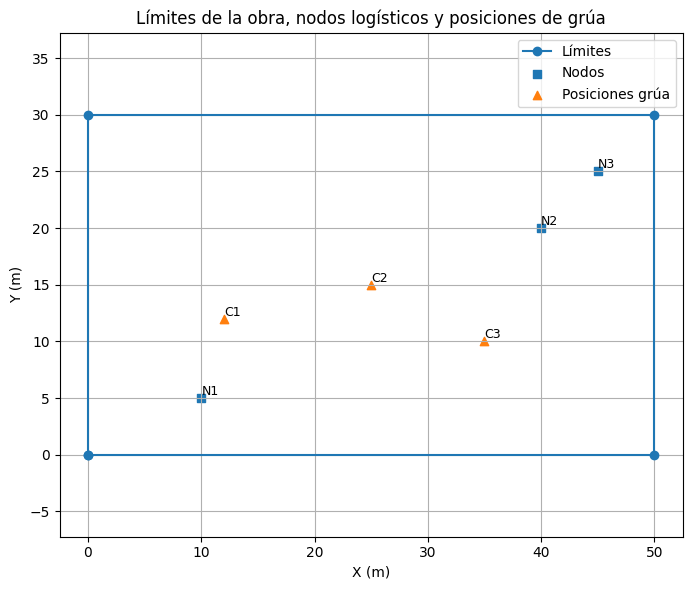

In [10]:
# Intentar usar validados; si no, usar originales
df_lim = globals().get('df_limites')
df_n   = globals().get('df_nodos_val', globals().get('df_nodos'))
df_g   = globals().get('df_grua_val',  globals().get('df_grua'))

# Polígono
x_poly = df_lim['X_m'].tolist()
y_poly = df_lim['Y_m'].tolist()
x_poly.append(x_poly[0]); y_poly.append(y_poly[0])

# Columnas de ID
id_col_nodos = 'NodeID' if 'NodeID' in df_n.columns else df_n.columns[0]
id_col_grua  = 'CraneID' if 'CraneID' in df_g.columns else df_g.columns[0]

# Filtrar por estado si existe
df_n_plot = df_n[df_n['estado'] == 'OK'] if 'estado' in df_n.columns else df_n
df_g_plot = df_g[df_g['estado'] == 'OK'] if 'estado' in df_g.columns else df_g

plt.figure(figsize=(7,6))

plt.plot(x_poly, y_poly, marker='o', linestyle='-', label='Límites')
plt.scatter(df_n_plot['X_m'], df_n_plot['Y_m'], marker='s', label='Nodos')
for _, r in df_n_plot.iterrows():
    plt.text(r['X_m'], r['Y_m'], str(r[id_col_nodos]), fontsize=9, ha='left', va='bottom')

plt.scatter(df_g_plot['X_m'], df_g_plot['Y_m'], marker='^', label='Posiciones grúa')
for _, r in df_g_plot.iterrows():
    plt.text(r['X_m'], r['Y_m'], str(r[id_col_grua]), fontsize=9, ha='left', va='bottom')

plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title('Límites de la obra, nodos logísticos y posiciones de grúa')
plt.axis('equal'); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

In [11]:
import math

# =============================
# Validaciones básicas de inputs
# =============================
required_grua_cols = {'CraneID', 'X_m', 'Y_m'}
required_nodo_cols = {'NodeID', 'X_m', 'Y_m'}

missing_grua = required_grua_cols - set(df_grua.columns)
missing_nodo = required_nodo_cols - set(df_nodos.columns)
if missing_grua:
    raise ValueError(f"Faltan columnas en df_grua: {missing_grua}")
if missing_nodo:
    raise ValueError(f"Faltan columnas en df_nodos: {missing_nodo}")

for var_name in ["RADIO_MIN", "MAX_LENGHT", "HOOK_HEIGHT"]:
    if var_name not in globals():
        raise ValueError(f"No encuentro la variable {var_name} en el entorno.")

# Convertir a numérico por seguridad
df_grua['X_m'] = pd.to_numeric(df_grua['X_m'], errors='coerce')
df_grua['Y_m'] = pd.to_numeric(df_grua['Y_m'], errors='coerce')
df_nodos['X_m'] = pd.to_numeric(df_nodos['X_m'], errors='coerce')
df_nodos['Y_m'] = pd.to_numeric(df_nodos['Y_m'], errors='coerce')

# Si existe Z_m, convertir también
if 'Z_m' in df_nodos.columns:
    df_nodos['Z_m'] = pd.to_numeric(df_nodos['Z_m'], errors='coerce')
if 'Z_m' in df_grua.columns:
    df_grua['Z_m'] = pd.to_numeric(df_grua['Z_m'], errors='coerce')

# Filtrar nodos con coordenadas válidas
df_nodos_valid = df_nodos.dropna(subset=['X_m','Y_m']).copy()

# =============================
# Función de evaluación por grúa
# =============================
def eval_crane_position(crane_row, nodes_df, rmin, rmax, hook_h):
    cx, cy = float(crane_row['X_m']), float(crane_row['Y_m'])
    crane_id = crane_row['CraneID']

    # Distancias planas (X,Y) desde la grúa a cada nodo
    dx = nodes_df['X_m'].astype(float) - cx
    dy = nodes_df['Y_m'].astype(float) - cy
    dist = np.sqrt(dx*dx + dy*dy)

    # Chequeos de radio mínimo y máximo
    outside_min_mask = dist > rmin            # True si está FUERA del radio mínimo
    inside_max_mask  = dist <= rmax           # True si está DENTRO del alcance máximo

    # Chequeo de altura de gancho (si no hay Z_m, lo marcamos como desconocido)
    if 'Z_m' in nodes_df.columns:
        below_hook_mask = nodes_df['Z_m'] < hook_h
        # Para NaN en Z_m, consideramos que NO pasa (requiere datos de cota)
        below_hook_mask = below_hook_mask.fillna(False)
        missing_z = nodes_df['Z_m'].isna()
    else:
        # Si no existe la columna Z_m, marcamos todo como desconocido
        below_hook_mask = pd.Series([False]*len(nodes_df), index=nodes_df.index)
        missing_z = pd.Series([True]*len(nodes_df), index=nodes_df.index)

    # Listas de violaciones
    nodes_violating_min  = nodes_df.loc[~outside_min_mask, 'NodeID'].tolist()   # adentro del rmin
    nodes_violating_max  = nodes_df.loc[~inside_max_mask,  'NodeID'].tolist()   # fuera del rmax
    nodes_violating_hook = nodes_df.loc[~below_hook_mask & ~missing_z, 'NodeID'].tolist()  # Z>=hook (con Z conocida)
    nodes_missing_z      = nodes_df.loc[missing_z, 'NodeID'].tolist()           # Z desconocida

    # Resumen booleano
    all_outside_min = outside_min_mask.all()
    all_inside_max  = inside_max_mask.all()
    # Para la altura, si hay Z desconocida, puedes decidir política:
    # - Opción estricta: exigir Z conocida y < hook para TODOS -> entonces False si hay missing_z
    # - Opción laxa: considerar missing_z como "no evaluado" pero no bloquear
    # Aquí iremos por la opción estricta por seguridad:
    all_below_hook  = below_hook_mask.all() and (not missing_z.any())

    # Métricas auxiliares
    min_dist = float(dist.min()) if len(dist) else np.nan
    max_dist = float(dist.max()) if len(dist) else np.nan

    # Notas
    notes = []
    if missing_z.any():
        notes.append(f"{missing_z.sum()} nodos sin Z_m")
    note_str = "; ".join(notes) if notes else ""

    return {
        'CraneID': crane_id,
        'min_dist_m': round(min_dist, 3),
        'max_dist_m': round(max_dist, 3),
        'all_outside_min': bool(all_outside_min),
        'all_inside_max':  bool(all_inside_max),
        'all_below_hook':  bool(all_below_hook),
        'viol_min_nodes':  ", ".join(nodes_violating_min) if nodes_violating_min else "",
        'viol_max_nodes':  ", ".join(nodes_violating_max) if nodes_violating_max else "",
        'viol_hook_nodes': ", ".join(nodes_violating_hook) if nodes_violating_hook else "",
        'missing_z_nodes': ", ".join(nodes_missing_z) if nodes_missing_z else "",
        'note': note_str
    }

# =============================
# Evaluación para todas las grúas
# =============================
results = []
for _, crow in df_grua.dropna(subset=['X_m','Y_m']).iterrows():
    res = eval_crane_position(
        crow,
        df_nodos_valid,
        rmin=float(RADIO_MIN),
        rmax=float(MAX_LENGHT),
        hook_h=float(HOOK_HEIGHT)
    )
    results.append(res)

df_evaluacion = pd.DataFrame(results)

# Ordenar columnas para lectura cómoda
cols_order = [
    'CraneID', 'min_dist_m', 'max_dist_m',
    'all_outside_min', 'all_inside_max', 'all_below_hook',
    'viol_min_nodes', 'viol_max_nodes', 'viol_hook_nodes', 'missing_z_nodes',
    'note'
]
df_evaluacion = df_evaluacion[cols_order]

print("Parámetros usados → RADIO_MIN =", RADIO_MIN, "| MAX_LENGHT =", MAX_LENGHT, "| HOOK_HEIGHT =", HOOK_HEIGHT)
print("\nResultado de evaluación por posición de grúa:")
print(df_evaluacion.to_string(index=False))

# (Opcional) Filtrar solo las posiciones que pasan todas las condiciones
df_ok = df_evaluacion[(df_evaluacion['all_outside_min']) &
                      (df_evaluacion['all_inside_max']) &
                      (df_evaluacion['all_below_hook'])].reset_index(drop=True)
print("\nPosiciones que cumplen TODAS las condiciones (radio min, radio max, altura):")
print(df_ok[['CraneID']])

Parámetros usados → RADIO_MIN = 2.9 | MAX_LENGHT = 80.0 | HOOK_HEIGHT = 81.5

Resultado de evaluación por posición de grúa:
CraneID  min_dist_m  max_dist_m  all_outside_min  all_inside_max  all_below_hook viol_min_nodes viol_max_nodes viol_hook_nodes missing_z_nodes note
     C1       7.280      35.468             True            True            True                                                                   
     C2      15.811      22.361             True            True            True                                                                   
     C3      11.180      25.495             True            True            True                                                                   

Posiciones que cumplen TODAS las condiciones (radio min, radio max, altura):
  CraneID
0      C1
1      C2
2      C3


# Capacidad de carga en cada nodo

In [12]:
# =========================
# 1) Obtener R_CAP y Pmax desde df_analisis
# =========================
if 'df_analisis' not in globals():
    raise ValueError("df_analisis no está definido. Debe contener columnas 'Radio' y 'Capacidad'.")

df_analisis = df_analisis.copy()
df_analisis['Radio'] = pd.to_numeric(df_analisis['Radio'], errors='coerce')
df_analisis['Capacidad'] = pd.to_numeric(df_analisis['Capacidad'], errors='coerce')

Pmax = df_analisis['Capacidad'].max()*1000
R_CAP = df_analisis.loc[df_analisis['Capacidad'] == Pmax/1000, 'Radio'].max()

print(f"Detectado desde df_analisis -> Pmax = {Pmax:.2f} t, R_CAP = {R_CAP:.2f} m")

# =========================
# 2) Validaciones básicas
# =========================
required_grua_cols = {"CraneID","X_m","Y_m"}
required_nodo_cols = {"NodeID","X_m","Y_m"}

if not required_grua_cols.issubset(df_grua.columns):
    raise ValueError(f"df_grua debe contener columnas {required_grua_cols}")
if not required_nodo_cols.issubset(df_nodos.columns):
    raise ValueError(f"df_nodos debe contener columnas {required_nodo_cols}")

for var in ["M","Q","D"]:
    if var not in globals():
        raise ValueError(f"No encuentro la variable {var} (M,Q,D). Defínelas antes de ejecutar.")

for df in (df_grua, df_nodos):
    for c in ("X_m","Y_m"):
        df[c] = pd.to_numeric(df[c], errors="coerce")

# =========================
# 3) Producto cartesiano y cálculo del radio
# =========================
gr = df_grua[["CraneID","X_m","Y_m"]].rename(columns={"X_m":"Xc","Y_m":"Yc"})
nd = df_nodos[["NodeID","X_m","Y_m"]].rename(columns={"X_m":"Xn","Y_m":"Yn"})
pairs = gr.merge(nd, how="cross")

dx = pairs["Xc"].astype(float) - pairs["Xn"].astype(float)
dy = pairs["Yc"].astype(float) - pairs["Yn"].astype(float)
pairs["R_m"] = np.hypot(dx, dy).round(2)

# =========================
# 4) Capacidad por tramos
# =========================
eps = 1e-12
mask_short = pairs["R_m"] <= float(R_CAP)
mask_long  = ~mask_short

if "MAX_LENGHT" in globals():
    reach_ok = pairs["R_m"] <= float(MAX_LENGHT)
else:
    reach_ok = pd.Series([True]*len(pairs), index=pairs.index)

valid_formula = (pairs["R_m"] - float(D)) > eps

P = pd.Series(np.nan, index=pairs.index, dtype=float)

P.loc[mask_short & reach_ok] = round(float(Pmax), 2)

apply_long = mask_long & valid_formula & reach_ok
P.loc[apply_long] = ((float(M) / (pairs.loc[apply_long, "R_m"] - float(D))) - float(Q)).round(2)

pairs["P_t"] = P

# =========================
# 5) Razones de invalidez
# =========================
reason = np.array([""]*len(pairs), dtype=object)
reason = np.where(~reach_ok, "fuera_alcance", reason)
reason = np.where(mask_long & ~valid_formula,
                  np.where(reason=="","R<=D (inválido)", reason + "; R<=D (inválido)"),
                  reason)

pairs["within_reach"] = reach_ok
pairs["valid_R_gt_D"] = valid_formula | mask_short
pairs["reason"] = reason

# =========================
# 6) Salidas
# =========================
df_result_long = pairs[["CraneID","NodeID","R_m","P_t","within_reach","valid_R_gt_D","reason"]].copy()

pivot_R = df_result_long.pivot(index="CraneID", columns="NodeID", values="R_m").round(2)
pivot_P = df_result_long.pivot(index="CraneID", columns="NodeID", values="P_t").round(2)

print("\nResultados (largo):")
print(df_result_long.to_string(index=False, float_format="%.2f"))

print("\nMatriz de radios R (m):")
print(pivot_R.to_string(float_format="%.2f"))

print("\nMatriz de capacidades P (kg):")
print(pivot_P.to_string(float_format="%.2f"))

Detectado desde df_analisis -> Pmax = 20000.00 t, R_CAP = 25.00 m

Resultados (largo):
CraneID NodeID   R_m      P_t  within_reach  valid_R_gt_D reason
     C1     N1  7.28 20000.00          True          True       
     C1     N2 29.12 16717.00          True          True       
     C1     N3 35.47 13193.96          True          True       
     C2     N1 18.03 20000.00          True          True       
     C2     N2 15.81 20000.00          True          True       
     C2     N3 22.36 20000.00          True          True       
     C3     N1 25.50 19542.71          True          True       
     C3     N2 11.18 20000.00          True          True       
     C3     N3 18.03 20000.00          True          True       

Matriz de radios R (m):
NodeID     N1    N2    N3
CraneID                  
C1       7.28 29.12 35.47
C2      18.03 15.81 22.36
C3      25.50 11.18 18.03

Matriz de capacidades P (kg):
NodeID        N1       N2       N3
CraneID                           
C1     

# Viajes mínimos entre cada nodo

In [13]:
# =========================
# 1) Unir demanda con materiales para obtener el peso por unidad
# =========================
df_demanda_pesos = df_demanda.merge(
    df_materiales[['Material_ID', 'Peso_unidad_kg']],
    on='Material_ID',
    how='left'  # para mantener todas las filas de df_demanda
)

# =========================
# 2) Calcular el peso total transportado
# =========================
df_demanda_pesos['Peso_total_kg'] = (df_demanda_pesos['Cantidad'] * df_demanda_pesos['Peso_unidad_kg']).round(2)

# =========================
# 3) Vista rápida del resultado
# =========================
print(df_demanda_pesos)


  FromNode ToNode Material_ID  Cantidad  Peso_unidad_kg  Peso_total_kg
0       N1     N2        LADR     17000             2.7        45900.0
1       N1     N3        ACER     15600            20.0       312000.0
2       N2     N1        CEME      9500            42.5       403750.0
3       N2     N3        VIGA      3400           144.0       489600.0
4       N3     N2        ACER      9800            20.0       196000.0


In [14]:
# =========================
# 1) Convertimos pivot_P a formato long para merge
# =========================
# pivot_P: index=CraneID, columns=NodeID
df_capacidad_long = pivot_P.reset_index().melt(
    id_vars="CraneID",
    var_name="NodeID",
    value_name="Capacidad_kg"
)
# Ahora df_capacidad_long tiene columnas: CraneID, NodeID, Capacidad_kg

# =========================
# 2) Expandir df_demanda_pesos para todas las grúas
# =========================
gruas = df_capacidad_long["CraneID"].unique()
df_demanda_exp = df_demanda_pesos.merge(pd.DataFrame({"CraneID": gruas}), how="cross")

# =========================
# 3) Obtener capacidades de FromNode y ToNode
# =========================
# Merge para FromNode
df_demanda_exp = df_demanda_exp.merge(
    df_capacidad_long.rename(columns={"NodeID":"FromNode", "Capacidad_kg":"Capacidad_FromNode"}),
    on=["CraneID","FromNode"],
    how="left"
)

# Merge para ToNode
df_demanda_exp = df_demanda_exp.merge(
    df_capacidad_long.rename(columns={"NodeID":"ToNode", "Capacidad_kg":"Capacidad_ToNode"}),
    on=["CraneID","ToNode"],
    how="left"
)

# =========================
# 4) Calcular capacidad limitante
# =========================
df_demanda_exp["Capacidad_limitante_kg"] = df_demanda_exp[["Capacidad_FromNode","Capacidad_ToNode"]].min(axis=1)

# =========================
# 5) Calcular número de viajes necesarios
# =========================
df_demanda_exp["Viajes_necesarios"] = np.ceil(df_demanda_exp["Peso_total_kg"] / df_demanda_exp["Capacidad_limitante_kg"]).astype(int)

# =========================
# 6) Selección de columnas finales
# =========================
df_resultados = df_demanda_exp[
    ["CraneID","FromNode","ToNode","Material_ID","Peso_total_kg","Capacidad_limitante_kg","Viajes_necesarios"]
].copy()

# =========================
# 7) Mostrar resultados
# =========================
print(df_resultados.to_string(index=False, float_format="%.2f"))


CraneID FromNode ToNode Material_ID  Peso_total_kg  Capacidad_limitante_kg  Viajes_necesarios
     C1       N1     N2        LADR       45900.00                16717.00                  3
     C2       N1     N2        LADR       45900.00                20000.00                  3
     C3       N1     N2        LADR       45900.00                19542.71                  3
     C1       N1     N3        ACER      312000.00                13193.96                 24
     C2       N1     N3        ACER      312000.00                20000.00                 16
     C3       N1     N3        ACER      312000.00                19542.71                 16
     C1       N2     N1        CEME      403750.00                16717.00                 25
     C2       N2     N1        CEME      403750.00                20000.00                 21
     C3       N2     N1        CEME      403750.00                19542.71                 21
     C1       N2     N3        VIGA      489600.00          

# Programación lineal del problema

In [15]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 107.0 MB/s eta 0:00:00


In [16]:
import pulp

# =========================
# Supongamos que df_demanda y df_grua ya existen
# df_demanda tiene columnas FromNode y ToNode
# df_grua tiene columna CraneID
# =========================

# 1️⃣ Obtener lista única de nodos
nodos = pd.Index(pd.concat([df_demanda['FromNode'], df_demanda['ToNode']]).unique())

# 2️⃣ Crear MultiIndex de 3 niveles: FromNode, ToNode, CraneID
multi_index_grua = pd.MultiIndex.from_product(
    [nodos, nodos, df_grua["CraneID"]],
    names=["FromNode", "ToNode", "CraneID"]
)

# Filtrar combinaciones donde FromNode != ToNode
multi_index_grua = multi_index_grua[
    multi_index_grua.get_level_values("FromNode") != multi_index_grua.get_level_values("ToNode")
]

# 3️⃣ Crear DataFrame de variables de PuLP + columnas para tiempos
m_vars_grua_df = pd.DataFrame({
    "var": [pulp.LpVariable(f"m_{i}_{j}_{c}", lowBound=0, cat="Integer")
            for i,j,c in multi_index_grua],
    "t_vertical": 0.0,
    "t_angular": 0.0,
    "t_radial": 0.0
}, index=multi_index_grua)

# 4️⃣ Mostrar resultado
print("Variables definidas (MultiIndex 3 niveles):")
print(m_vars_grua_df)


Variables definidas (MultiIndex 3 niveles):
                                var  t_vertical  t_angular  t_radial
FromNode ToNode CraneID                                             
N1       N2     C1       m_N1_N2_C1         0.0        0.0       0.0
                C2       m_N1_N2_C2         0.0        0.0       0.0
                C3       m_N1_N2_C3         0.0        0.0       0.0
         N3     C1       m_N1_N3_C1         0.0        0.0       0.0
                C2       m_N1_N3_C2         0.0        0.0       0.0
                C3       m_N1_N3_C3         0.0        0.0       0.0
N2       N1     C1       m_N2_N1_C1         0.0        0.0       0.0
                C2       m_N2_N1_C2         0.0        0.0       0.0
                C3       m_N2_N1_C3         0.0        0.0       0.0
         N3     C1       m_N2_N3_C1         0.0        0.0       0.0
                C2       m_N2_N3_C2         0.0        0.0       0.0
                C3       m_N2_N3_C3         0.0        0.0 

In [17]:
h=1.5
Vv=1
# Extraer niveles del MultiIndex
from_nodes = m_vars_grua_df.index.get_level_values("FromNode")
to_nodes = m_vars_grua_df.index.get_level_values("ToNode")

# Mapear directamente
Z_from = from_nodes.map(df_nodos.set_index("NodeID")["Z_m"])
Z_to   = to_nodes.map(df_nodos.set_index("NodeID")["Z_m"])

# Calcular tiempo vertical
m_vars_grua_df["t_vertical"] = (np.abs(Z_to - Z_from) + 2*h) / Vv
m_vars_grua_df["t_vertical"] = m_vars_grua_df["t_vertical"].round(2)

print(m_vars_grua_df)


                                var  t_vertical  t_angular  t_radial
FromNode ToNode CraneID                                             
N1       N2     C1       m_N1_N2_C1         3.0        0.0       0.0
                C2       m_N1_N2_C2         3.0        0.0       0.0
                C3       m_N1_N2_C3         3.0        0.0       0.0
         N3     C1       m_N1_N3_C1         3.0        0.0       0.0
                C2       m_N1_N3_C2         3.0        0.0       0.0
                C3       m_N1_N3_C3         3.0        0.0       0.0
N2       N1     C1       m_N2_N1_C1         3.0        0.0       0.0
                C2       m_N2_N1_C2         3.0        0.0       0.0
                C3       m_N2_N1_C3         3.0        0.0       0.0
         N3     C1       m_N2_N3_C1         3.0        0.0       0.0
                C2       m_N2_N3_C2         3.0        0.0       0.0
                C3       m_N2_N3_C3         3.0        0.0       0.0
N3       N1     C1       m_N3_N1_C

In [18]:
# --- Función para distancia 2D ---
def distancia_2d(p, q):
    x1, y1 = p
    x2, y2 = q
    return math.hypot(x2 - x1, y2 - y1)

# --- Función para calcular ángulo θ entre Si-Tk-Dj usando ley de cosenos ---
def angulo_ley_cosenos(p_Si, p_Tk, p_Dj):
    dist_Si_Tk = distancia_2d(p_Si, p_Tk)
    dist_Dj_Tk = distancia_2d(p_Dj, p_Tk)
    dist_Si_Dj = distancia_2d(p_Si, p_Dj)

    numerador   = dist_Si_Tk**2 + dist_Dj_Tk**2 - dist_Si_Dj**2
    denominador = 2 * dist_Si_Tk * dist_Dj_Tk

    # Evitar errores numéricos
    if denominador == 0:
        return 0.0  # Si coinciden puntos, el ángulo es 0
    cos_theta = max(-1.0, min(1.0, numerador / denominador))
    theta_rad = math.acos(cos_theta)
    theta_deg = math.degrees(theta_rad)
    return theta_rad, theta_deg

# --- Parámetros de velocidad ---
V_r   = 1.0    # m/s
V_ang = 1.0   # °/s

# --- Mapas para obtener coordenadas de los nodos y grúas ---
coord_nodos_map = df_nodos.set_index("NodeID")[["X_m","Y_m"]].to_dict("index")
coord_gruas_map = df_grua.set_index("CraneID")[["X_m","Y_m"]].to_dict("index")

# --- Función para calcular tiempos radial y angular para cada fila del MultiIndex ---
def calcular_tiempos(row):
    from_node = row.name[0]
    to_node   = row.name[1]
    crane_id  = row.name[2]

    # Coordenadas en 2D
    Si = (coord_nodos_map[from_node]["X_m"], coord_nodos_map[from_node]["Y_m"])
    Dj = (coord_nodos_map[to_node]["X_m"], coord_nodos_map[to_node]["Y_m"])
    Tk = (coord_gruas_map[crane_id]["X_m"], coord_gruas_map[crane_id]["Y_m"])

    # Distancias
    dist_Si_Tk = distancia_2d(Si, Tk)
    dist_Dj_Tk = distancia_2d(Dj, Tk)

    # Tiempo radial
    T_r = abs(dist_Si_Tk - dist_Dj_Tk) / V_r

    # Tiempo angular
    _, theta_deg = angulo_ley_cosenos(Si, Tk, Dj)
    T_ang = theta_deg / V_ang

    return pd.Series({"t_radial": round(T_r, 2), "t_angular": round(T_ang, 2)})

# --- Aplicar .map a todo el MultiIndex (fila por fila) ---
m_vars_grua_df[["t_radial","t_angular"]] = m_vars_grua_df.apply(calcular_tiempos, axis=1)

# --- Mostrar resultado ---
print(m_vars_grua_df)

                                var  t_vertical  t_angular  t_radial
FromNode ToNode CraneID                                             
N1       N2     C1       m_N1_N2_C1         3.0     121.89     21.84
                C2       m_N1_N2_C2         3.0     164.74      2.22
                C3       m_N1_N2_C3         3.0     127.87     14.31
         N3     C1       m_N1_N3_C1         3.0     127.45     28.19
                C2       m_N1_N3_C2         3.0     172.87      4.33
                C3       m_N1_N3_C3         3.0     135.00      7.47
N2       N1     C1       m_N2_N1_C1         3.0     121.89     21.84
                C2       m_N2_N1_C2         3.0     164.74      2.22
                C3       m_N2_N1_C3         3.0     127.87     14.31
         N3     C1       m_N2_N3_C1         3.0       5.56      6.35
                C2       m_N2_N3_C2         3.0       8.13      6.55
                C3       m_N2_N3_C3         3.0       7.13      6.85
N3       N1     C1       m_N3_N1_C

In [19]:
# Calcular la columna t_total
m_vars_grua_df["t_total"] = (
    (m_vars_grua_df[["t_vertical", "t_angular", "t_radial"]].max(axis=1) +
     m_vars_grua_df["t_vertical"] +
     m_vars_grua_df["t_angular"] +
     m_vars_grua_df["t_radial"]) / 2
) + 6/Vv

# Redondear a 2 decimales si quieres consistencia con las otras columnas
m_vars_grua_df["t_total"] = m_vars_grua_df["t_total"].round(2)

# Mostrar resultado
print(m_vars_grua_df)

                                var  t_vertical  t_angular  t_radial  t_total
FromNode ToNode CraneID                                                      
N1       N2     C1       m_N1_N2_C1         3.0     121.89     21.84   140.31
                C2       m_N1_N2_C2         3.0     164.74      2.22   173.35
                C3       m_N1_N2_C3         3.0     127.87     14.31   142.52
         N3     C1       m_N1_N3_C1         3.0     127.45     28.19   149.04
                C2       m_N1_N3_C2         3.0     172.87      4.33   182.54
                C3       m_N1_N3_C3         3.0     135.00      7.47   146.24
N2       N1     C1       m_N2_N1_C1         3.0     121.89     21.84   140.31
                C2       m_N2_N1_C2         3.0     164.74      2.22   173.35
                C3       m_N2_N1_C3         3.0     127.87     14.31   142.52
         N3     C1       m_N2_N3_C1         3.0       5.56      6.35    16.63
                C2       m_N2_N3_C2         3.0       8.13      

In [20]:
# Suponemos que m_vars_grua_df ya contiene las variables de optimización y tiempos (t_vertical, t_angular, t_radial, t_total)
# m_vars_grua_df: MultiIndex [FromNode, ToNode, CraneID]

# Lista de CraneIDs
cranes = m_vars_grua_df.index.get_level_values("CraneID").unique()

# Crear un problema para cada CraneID
problems = {}  # Diccionario para almacenar los problemas de optimización para cada grúa

for crane_id in cranes:
    # Filtramos las variables para la grúa actual
    vars_crane = m_vars_grua_df[m_vars_grua_df.index.get_level_values("CraneID") == crane_id]

    # Crear un nuevo problema de optimización para la grúa actual
    prob = pulp.LpProblem(f"Minimizar_Tiempo_Viajes_{crane_id}", pulp.LpMinimize)

    # Definir la función objetivo: minimizar el tiempo total de los viajes para esta grúa
    # Multiplicamos cada variable m_Ni_Nj por el tiempo correspondiente en m_vars_grua_df
    tiempo_total_objetivo = pulp.lpSum(vars_crane["var"] * vars_crane["t_total"])

    prob += tiempo_total_objetivo, "Tiempo_Total_Viajes"

    # Definir restricciones de balance para cada nodo en esta grúa
    nodos = pd.Index(pd.concat([df_demanda['FromNode'], df_demanda['ToNode']]).unique())  # Lista de nodos

    for nodo in nodos:
        # Variables que salen del nodo
        salen = pulp.lpSum(vars_crane.xs(nodo, level="FromNode")["var"])

        # Variables que llegan al nodo
        llegan = pulp.lpSum(vars_crane.xs(nodo, level="ToNode")["var"])

        # Restricción de balance: salen - llegan == 0
        restriccion = salen - llegan == 0
        prob += restriccion, f"Balance_{nodo}"

    # Almacenar el problema para cada grúa
    problems[crane_id] = prob

# =========================
# 7️⃣ Imprimir las restricciones y funciones objetivo de los problemas
# =========================
for crane_id, prob in problems.items():
    print(f"\nProblema de PuLP para {crane_id}:")
    print(f"Función objetivo: {prob.objective}")
    print("\nRestricciones de balance:")
    for name, constraint in prob.constraints.items():
        print(f"{name}: {constraint}")



Problema de PuLP para C1:
Función objetivo: 140.31*m_N1_N2_C1 + 149.04*m_N1_N3_C1 + 140.31*m_N2_N1_C1 + 16.63*m_N2_N3_C1 + 149.04*m_N3_N1_C1 + 16.63*m_N3_N2_C1

Restricciones de balance:
Balance_N1: m_N1_N2_C1 + m_N1_N3_C1 - m_N2_N1_C1 - m_N3_N1_C1 = -0.0
Balance_N2: -m_N1_N2_C1 + m_N2_N1_C1 + m_N2_N3_C1 - m_N3_N2_C1 = -0.0
Balance_N3: -m_N1_N3_C1 - m_N2_N3_C1 + m_N3_N1_C1 + m_N3_N2_C1 = -0.0

Problema de PuLP para C2:
Función objetivo: 173.35*m_N1_N2_C2 + 182.54*m_N1_N3_C2 + 173.35*m_N2_N1_C2 + 18.9*m_N2_N3_C2 + 182.54*m_N3_N1_C2 + 18.9*m_N3_N2_C2

Restricciones de balance:
Balance_N1: m_N1_N2_C2 + m_N1_N3_C2 - m_N2_N1_C2 - m_N3_N1_C2 = -0.0
Balance_N2: -m_N1_N2_C2 + m_N2_N1_C2 + m_N2_N3_C2 - m_N3_N2_C2 = -0.0
Balance_N3: -m_N1_N3_C2 - m_N2_N3_C2 + m_N3_N1_C2 + m_N3_N2_C2 = -0.0

Problema de PuLP para C3:
Función objetivo: 142.52*m_N1_N2_C3 + 146.24*m_N1_N3_C3 + 142.52*m_N2_N1_C3 + 18.06*m_N2_N3_C3 + 146.24*m_N3_N1_C3 + 18.06*m_N3_N2_C3

Restricciones de balance:
Balance_N1: m_N1_N2_

In [21]:
# Ejemplo de los DataFrames (reemplaza con tu propio DataFrame)
# m_vars_grua_df: DataFrame del primer conjunto de datos
# df_resultados: DataFrame del segundo conjunto de datos

# Realizamos el merge entre ambos DataFrames por las columnas 'CraneID', 'FromNode' y 'ToNode'
merged_df = pd.merge(m_vars_grua_df, df_resultados[['CraneID', 'FromNode', 'ToNode', 'Viajes_necesarios']],
                     on=['CraneID', 'FromNode', 'ToNode'], how='left')
# Reemplazamos los valores NaN por 0
merged_df = merged_df.fillna(0)

# Visualizamos el resultado de manera sencilla
merged_df  # Muestra las primeras filas del DataFrame resultante


,CraneID,FromNode,ToNode,var,t_vertical,t_angular,t_radial,t_total,Viajes_necesarios
0,C1,N1,N2,m_N1_N2_C1,3.0,121.89,21.84,140.31,3.0
1,C2,N1,N2,m_N1_N2_C2,3.0,164.74,2.22,173.35,3.0
2,C3,N1,N2,m_N1_N2_C3,3.0,127.87,14.31,142.52,3.0
3,C1,N1,N3,m_N1_N3_C1,3.0,127.45,28.19,149.04,24.0
4,C2,N1,N3,m_N1_N3_C2,3.0,172.87,4.33,182.54,16.0
5,C3,N1,N3,m_N1_N3_C3,3.0,135.00,7.47,146.24,16.0
6,C1,N2,N1,m_N2_N1_C1,3.0,121.89,21.84,140.31,25.0
7,C2,N2,N1,m_N2_N1_C2,3.0,164.74,2.22,173.35,21.0
8,C3,N2,N1,m_N2_N1_C3,3.0,127.87,14.31,142.52,21.0
9,C1,N2,N3,m_N2_N3_C1,3.0,5.56,6.35,16.63,38.0


In [22]:
# import pulp
# import pandas as pd

# # Supongamos que 'merged_df' es el DataFrame con la información que nos proporcionaste

# # Crear un diccionario para almacenar los 3 problemas de optimización, uno para cada grúa (C1, C2, C3)
# problemas = {}

# # Crear un problema de optimización para cada crane (C1, C2, C3)
# for crane in merged_df['CraneID'].unique():
#     # Crear el problema de optimización para cada grúa
#     problem = pulp.LpProblem(f"Minimizar_tiempo_total_de_viajes_{crane}", pulp.LpMinimize)

#     # Crear las variables de decisión m_Ni_Nj_Ck para cada combinación de FromNode, ToNode y CraneID
#     variables = {
#         (row['FromNode'], row['ToNode']): pulp.LpVariable(f"m_{row['FromNode']}_{row['ToNode']}_{crane}", lowBound=0, cat="Integer")
#         for _, row in merged_df[merged_df['CraneID'] == crane].iterrows()
#     }

#     # Función objetivo: minimizar la suma de m_Ni_Nj_Ck * t_total para la grúa actual (C1, C2 o C3)
#     problem += pulp.lpSum(variables[(row['FromNode'], row['ToNode'])] * row['t_total']
#                           for _, row in merged_df[merged_df['CraneID'] == crane].iterrows()), f"Tiempo_total_de_viajes_{crane}"

#     # Agregar restricciones de balance de viajes para cada nodo
#     nodos = merged_df['FromNode'].unique()  # O también 'ToNode', ambos deberían ser iguales

#     for nodo in nodos:
#         # Restricción de balance para el nodo N_i (salidas - entradas = 0)
#         # Sumatoria de m_Ni_Nj_Ck para los viajes que salen de N_i (FromNode == N_i)
#         # menos sumatoria de m_Nj_Ni_Ck para los viajes que entran a N_i (ToNode == N_i)

#         salida = pulp.lpSum(variables[(nodo, row['ToNode'])] for _, row in merged_df[merged_df['FromNode'] == nodo].iterrows())
#         entrada = pulp.lpSum(variables[(row['FromNode'], nodo)] for _, row in merged_df[merged_df['ToNode'] == nodo].iterrows())

#         # Restricción de balance de viajes: salida - entrada = 0
#         problem += (salida - entrada == 0, f"Restriccion_balance_{nodo}_{crane}")

#     # Almacenar el problema en el diccionario
#     problemas[crane] = problem

# # Mostrar la función objetivo y las restricciones de cada uno de los problemas
# for crane, problem in problemas.items():
#     print(f"Función Objetivo para la grúa {crane}:")
#     print(problem.objective)
#     print("\nRestricciones:")
#     for constraint in problem.constraints.values():
#         print(constraint)
#     print("\n")


In [23]:
# import pulp
# import pandas as pd

# # Supongamos que 'merged_df' es el DataFrame con la información proporcionada

# # Crear un diccionario para almacenar los problemas de optimización por grúa (C1, C2, C3)
# problemas = {}

# for crane in merged_df['CraneID'].unique():
#     # ---- Filtrar por la grúa actual ----
#     dfc = merged_df[merged_df['CraneID'] == crane].copy()

#     # ---- Definir el problema ----
#     problem = pulp.LpProblem(f"Minimizar_tiempo_total_de_viajes_{crane}", pulp.LpMinimize)

#     # ---- Variables de decisión m_{i}_{j}_{crane} para los arcos de esta grúa ----
#     # Si hubiera filas duplicadas (mismo FromNode-ToNode), las colapsamos al crear el set de arcos
#     arcos = dfc[['FromNode', 'ToNode']].drop_duplicates()
#     variables = {
#         (row.FromNode, row.ToNode): pulp.LpVariable(
#             f"m_{row.FromNode}_{row.ToNode}_{crane}", lowBound=0, cat="Integer"
#         )
#         for row in arcos.itertuples(index=False)
#     }

#     # ---- Función objetivo: minimizar sum(m_ij * t_total_ij) para esta grúa ----
#     # Si existieran duplicados (i,j) con distintos t_total, podrías agrupar primero.
#     problem += pulp.lpSum(
#         variables[(row.FromNode, row.ToNode)] * row.t_total
#         for row in dfc.itertuples(index=False)
#     ), f"Tiempo_total_de_viajes_{crane}"

#     # ---- Restricciones de balance: para todos los nodos de esta grúa ----
#     nodos = pd.unique(pd.concat([dfc['FromNode'], dfc['ToNode']]))

#     for nodo in nodos:
#         # Pares (i=nodo, j) únicos que salen
#         out_pairs = [(nodo, j) for j in dfc.loc[dfc['FromNode'] == nodo, 'ToNode'].unique()]
#         # Pares (i, j=nodo) únicos que entran
#         in_pairs  = [(i, nodo) for i in dfc.loc[dfc['ToNode']   == nodo, 'FromNode'].unique()]

#         salida  = pulp.lpSum(variables[(i, j)] for (i, j) in out_pairs if (i, j) in variables)
#         entrada = pulp.lpSum(variables[(i, j)] for (i, j) in in_pairs  if (i, j) in variables)

#         problem += (salida - entrada == 0, f"Restriccion_balance_{nodo}_{crane}")

#     # ---- (Opcional) Si quieres evitar solución trivial m=0 usando Viajes_necesarios ----
#     # for row in dfc.itertuples(index=False):
#     #     problem += variables[(row.FromNode, row.ToNode)] >= row.Viajes_necesarios, \
#     #                f"Demanda_min_{row.FromNode}_{row.ToNode}_{crane}"

#     # Guardar el problema
#     problemas[crane] = problem

# # Mostrar la función objetivo y las restricciones de cada problema
# for crane, problem in problemas.items():
#     print(f"Función Objetivo para la grúa {crane}:")
#     print(problem.objective)
#     print("\nRestricciones:")
#     for name, constraint in problem.constraints.items():
#         print(constraint)
#     print("\n")


In [24]:
# import math  # (Opcional) si quieres redondear hacia arriba Viajes_necesarios con ceil

# Supongamos que 'merged_df' es el DataFrame con la información proporcionada

# Crear un diccionario para almacenar los problemas de optimización por grúa (C1, C2, C3)
problemas = {}

for crane in merged_df['CraneID'].unique():
    # ---- Filtrar por la grúa actual ----
    dfc = merged_df[merged_df['CraneID'] == crane].copy()

    # ---- Definir el problema ----
    problem = pulp.LpProblem(f"Minimizar_tiempo_total_de_viajes_{crane}", pulp.LpMinimize)

    # ---- Variables de decisión m_{i}_{j}_{crane} para los arcos de esta grúa ----
    arcos = dfc[['FromNode', 'ToNode']].drop_duplicates()
    variables = {
        (row.FromNode, row.ToNode): pulp.LpVariable(
            f"m_{row.FromNode}_{row.ToNode}_{crane}", lowBound=0, cat="Integer"
        )
        for row in arcos.itertuples(index=False)
    }

    # ---- Función objetivo: minimizar sum(m_ij * t_total_ij) para esta grúa ----
    problem += pulp.lpSum(
        variables[(row.FromNode, row.ToNode)] * row.t_total
        for row in dfc.itertuples(index=False)
    ), f"Tiempo_total_de_viajes_{crane}"

    # ---- Restricciones de balance (salidas - entradas = 0) por nodo ----
    nodos = pd.unique(pd.concat([dfc['FromNode'], dfc['ToNode']]))
    for nodo in nodos:
        out_pairs = [(nodo, j) for j in dfc.loc[dfc['FromNode'] == nodo, 'ToNode'].unique()]
        in_pairs  = [(i, nodo) for i in dfc.loc[dfc['ToNode']   == nodo, 'FromNode'].unique()]

        salida  = pulp.lpSum(variables[(i, j)] for (i, j) in out_pairs if (i, j) in variables)
        entrada = pulp.lpSum(variables[(i, j)] for (i, j) in in_pairs  if (i, j) in variables)

        problem += (salida - entrada == 0, f"Restriccion_balance_{nodo}_{crane}")

    # ---- NUEVAS: Restricciones de mínimos de viajes por arco ----
    # m_{i,j,crane} >= Viajes_necesarios_{i,j,crane}
    for row in dfc.itertuples(index=False):
        par = (row.FromNode, row.ToNode)
        if par in variables:
            req = 0 if pd.isna(row.Viajes_necesarios) else row.Viajes_necesarios
            # Si quisieras asegurar enteros ante floats raros: req = int(math.ceil(req))
            problem += variables[par] >= req, f"Min_viajes_{row.FromNode}_{row.ToNode}_{crane}"

    # Guardar el problema
    problemas[crane] = problem

# Mostrar la función objetivo y las restricciones de cada problema
for crane, problem in problemas.items():
    print(f"Función Objetivo para la grúa {crane}:")
    print(problem.objective)
    print("\nRestricciones:")
    for name, constraint in problem.constraints.items():
        print(constraint)
    print("\n")


Función Objetivo para la grúa C1:
140.31*m_N1_N2_C1 + 149.04*m_N1_N3_C1 + 140.31*m_N2_N1_C1 + 16.63*m_N2_N3_C1 + 149.04*m_N3_N1_C1 + 16.63*m_N3_N2_C1

Restricciones:
m_N1_N2_C1 + m_N1_N3_C1 - m_N2_N1_C1 - m_N3_N1_C1 = -0.0
-m_N1_N2_C1 + m_N2_N1_C1 + m_N2_N3_C1 - m_N3_N2_C1 = -0.0
-m_N1_N3_C1 - m_N2_N3_C1 + m_N3_N1_C1 + m_N3_N2_C1 = -0.0
m_N1_N2_C1 >= 3.0
m_N1_N3_C1 >= 24.0
m_N2_N1_C1 >= 25.0
m_N2_N3_C1 >= 38.0
m_N3_N1_C1 >= -0.0
m_N3_N2_C1 >= 15.0


Función Objetivo para la grúa C2:
173.35*m_N1_N2_C2 + 182.54*m_N1_N3_C2 + 173.35*m_N2_N1_C2 + 18.9*m_N2_N3_C2 + 182.54*m_N3_N1_C2 + 18.9*m_N3_N2_C2

Restricciones:
m_N1_N2_C2 + m_N1_N3_C2 - m_N2_N1_C2 - m_N3_N1_C2 = -0.0
-m_N1_N2_C2 + m_N2_N1_C2 + m_N2_N3_C2 - m_N3_N2_C2 = -0.0
-m_N1_N3_C2 - m_N2_N3_C2 + m_N3_N1_C2 + m_N3_N2_C2 = -0.0
m_N1_N2_C2 >= 3.0
m_N1_N3_C2 >= 16.0
m_N2_N1_C2 >= 21.0
m_N2_N3_C2 >= 25.0
m_N3_N1_C2 >= -0.0
m_N3_N2_C2 >= 10.0


Función Objetivo para la grúa C3:
142.52*m_N1_N2_C3 + 146.24*m_N1_N3_C3 + 142.52*m_N2_N1_C3 + 

In [25]:
# Resolver con el solver por defecto (CBC) y mostrar resultados
solver = pulp.PULP_CBC_CMD(msg=False)

for crane, problem in problemas.items():
    problem.solve(solver)
    obj_val = pulp.value(problem.objective)
    print(f"=== Resultados para {crane} ===")
    print(f"Valor de la función objetivo: {obj_val:.2f}")
    print("Valores de variables:")
    for v in sorted(problem.variables(), key=lambda x: x.name):
        val = v.varValue if v.varValue is not None else float('nan')
        print(f"  {v.name} = {val:.2f}")
    print()


=== Resultados para C1 ===
Valor de la función objetivo: 9433.46
Valores de variables:
  m_N1_N2_C1 = 3.00
  m_N1_N3_C1 = 24.00
  m_N2_N1_C1 = 25.00
  m_N2_N3_C1 = 38.00
  m_N3_N1_C1 = 2.00
  m_N3_N2_C1 = 60.00

=== Resultados para C2 ===
Valor de la función objetivo: 8675.14
Valores de variables:
  m_N1_N2_C2 = 5.00
  m_N1_N3_C2 = 16.00
  m_N2_N1_C2 = 21.00
  m_N2_N3_C2 = 25.00
  m_N3_N1_C2 = 0.00
  m_N3_N2_C2 = 41.00

=== Resultados para C3 ===
Valor de la función objetivo: 7237.32
Valores de variables:
  m_N1_N2_C3 = 5.00
  m_N1_N3_C3 = 16.00
  m_N2_N1_C3 = 21.00
  m_N2_N3_C3 = 25.00
  m_N3_N1_C3 = 0.00
  m_N3_N2_C3 = 41.00

